<a href="https://colab.research.google.com/github/Guo-bot-1998/Appendicitis/blob/master/Appendicitis_colab_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import

In [131]:
!pip install timm
!pip install tqdm
!pip install kora

In [132]:
import nibabel as nib
import numpy as np
import os
import pandas as pd
import nibabel as nib
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import random
import re
import json
import timm
import gdown
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
from google.colab import widgets

from tqdm.asyncio import tqdm
from kora.xattr import get_id
import asyncio
import aiohttp
import nest_asyncio
nest_asyncio.apply()
loop = asyncio.get_event_loop()

## 存取

In [133]:
def get_data_disk(driveroot, targetdir):
  """從雲端資料夾targetdir下載檔案到colab root底下同名資料夾
  只下載沒有下載的檔案.

  driveroot為雲端檔案資料夾root"""

  if not os.path.exists('/content/' + targetdir):
    os.makedirs(targetdir)
    print(f"making {targetdir} dir...")

  files_on_drive = os.listdir(driveroot+'/'+targetdir)
  files_in_localdir = os.listdir(f"/content/{targetdir}")
  files_to_download = [f for f in files_on_drive if f not in files_in_localdir]
  files = [(filename, get_id(f'{driveroot}/{targetdir}/{filename}')) for filename in files_to_download]


  for idx, (name, file_id) in enumerate(files):

    if not file_id:
      print(f"未找到文件: {name}")
      continue

    # 下载文件
    request = drive_service.files().get_media(fileId=file_id)
    fh = io.BytesIO()
    downloader = MediaIoBaseDownload(fh, request)

    done = False
    while not done:
      status, done = downloader.next_chunk()
      # print(f"下载 {name} 进度: {int(status.progress() * 100)}%")

    # 将文件内容写入本地文件
    local_file_path = os.path.join('/content', targetdir, name)

    with open(local_file_path, 'wb') as f:
      fh.seek(0)
      f.write(fh.read())

    print(f"{idx+1}/{len(files)}: {name} downloaded")




async def download_file(session, name, file_id, file_path, token):
  if not file_id:
    print(f"未找到文件: {name}")
    return

  download_url = f"https://www.googleapis.com/drive/v3/files/{file_id}?alt=media"
  headers = {"Authorization": f"Bearer {token}"}

  async with session.get(download_url, headers=headers) as response:
    if response.status == 200:
      with open(file_path, 'wb') as f:
        while True:
          chunk = await response.content.read(1024)
          if not chunk:
            break
          f.write(chunk)
      # print(f"Downloaded: {name}...")
    else:
      print(f"Failed: {name}!! status: {response.status}")


# 定义异步获取数据的主函数
async def get_data_disk_async(driveroot, targetdir, token):
  # 生成文件夹的绝对路径
  drive_folder_path = os.path.join(driveroot, targetdir)
  local_folder_path = os.path.join('/content', targetdir)

  if not os.path.exists(local_folder_path):
    os.makedirs(local_folder_path)
    print(f"making {targetdir} dir...")

  # 获取文件列表
  files_on_drive = os.listdir(drive_folder_path)
  files_in_localdir = os.listdir(local_folder_path)
  files_to_download = [f for f in files_on_drive if f not in files_in_localdir]
  files = [(filename, get_id(os.path.join(drive_folder_path, filename))) for filename in files_to_download]

  async with aiohttp.ClientSession() as session:
    tasks = []
    for idx, (name, file_id) in enumerate(files):
      local_file_path = os.path.join(local_folder_path, name)
      task = asyncio.create_task(download_file(session, name, file_id, local_file_path, token))
      tasks.append(task)

    # 使用 tqdm 包装任务列表以显示进度条
    for f in tqdm.as_completed(tasks, total=len(tasks)):
      await f



def process_data2(traindir, shift=0, termi=10, dropFalse=0.85, dropPos=0, files=None):
  """Reading data in "traindir" and process them.
  Taking care of memory efficiency"

  Args:
    shift: 從第幾個開始讀取 (當files給定時無效)
    termi: 讀取幾個 (當files給定時無效)
    dropFalse: 被刪除的有闌尾炎的張數比例
    dropPos: 被刪除的有闌尾炎的張數比例
    files: 要讀取的檔案id，預設是None

  Returns:
    images: 输出的图像数据
    labels: 输出的标签数据
  """

  if not files:
    filelist = os.listdir(traindir)
    filelist = filelist[shift:shift+termi]
  else: filelist = files

  return loading_data(traindir, filelist, dropFalse, dropPos)



def loading_data(traindir, filelist, dropFalse, dropPos)\
 -> tuple[torch.tensor, torch.tensor]:

  print(f"reading {traindir=}...")
  labels_ = read_label(labelpath)

  if labels_.index.name != 'id':
    labels_.set_index('id', inplace=True)

  #裁減過的圖片放在Cropped_[範圍]的資料夾下,用路徑名稱判斷資料使否裁減過
  cropmatch = re.search(r'Cropped', traindir)
  if not cropmatch:
    print("讀取未切片的資料夾")
    xlim, ylim, zlim = [0,512], [0,512], [0,None]
  else:
    #範圍 = xstart-xend_ystart-yend_zstart-zend
    ismatch = re.search(r'(\d+-\d+)_(\d+-\d+)_(\d+-\d+)', traindir)
    if ismatch:
      dimens = ismatch.group(0)
      labelidx = dimens.split('_')
      xlim = [int(idx) for idx in labelidx[0].split('-')]
      ylim = [int(idx) for idx in labelidx[1].split('-')]
      zlim = [int(idx) for idx in labelidx[2].split('-')]
      print(f"{xlim=}\n{ylim=}\n{zlim=}")
      if xlim[0] >= xlim[1] or ylim[0] >= ylim[1] or zlim[0] >= zlim[1]:
        print("切片格式不正确")
        return
    else:
      print("切片格式不正确")
      return



  # preallocated(有無裁減過影響preallocated的大小)
  if not cropmatch:
    selecteds = [labels_.loc[labels_.index.str.startswith(afile.strip('.nii.gz')+'_')] for afile in filelist]
    numcuts = [len(selected) for selected in selecteds]
    numcuts = sum(numcuts)
  else:
    numcuts = (zlim[1]-zlim[0]) * len(filelist)
  images = torch.zeros(numcuts,1, ylim[-1]-ylim[0],xlim[-1]-xlim[0])
  labels = -torch.ones(numcuts)
  nimgs = 0
  nprocess = 0

  for key in filelist:
    file_path = os.path.join(traindir, key)
    key = key.strip('.nii.gz')
    scan  = labels_.loc[labels_.index.str.startswith(key+'_')]
    value = nib.load(file_path).get_fdata()

    label_t = torch.tensor(scan['label'][zlim[0]:zlim[-1]]) #每個scan只拿zlim範圍，不滿60張的拿完
    image_t = torch.from_numpy(value).float().permute(2, 0, 1).unsqueeze(1)

    #有幾筆不是512x512, 剪成512x512
    if (not cropmatch) and (image_t.shape[2] != 512 or image_t.shape[3] != 512):
      image_t = cropping(image_t)

    image_t, label_t = remove_false_images(image_t, label_t, dropFalse)
    image_t, label_t = remove_positive_images(image_t, label_t, dropPos)

    n_new = len(label_t)

    images[nimgs:nimgs+n_new] = image_t
    labels[nimgs:nimgs+n_new] = label_t
    nimgs += len(label_t)
    print(f"Process {nprocess}: {key} finished...")
    nprocess += 1


  #after drop
  counts = count_zero(images)
  images = torch.asarray(images[:len(images)-counts])
  labels = labels[labels != -1]

  return images, labels.float()




def read_test(testdir,shift=0,termi=10):
  """Reading data in "testdir"
  not memory efficient
  Args:
    shift: 從第幾個開始讀取
    termi: 讀取幾個
  Returns:
    images: 输出的图像数据
    scans_info: 每個scan的檔名和切片數(原本nii檔所包含的數量)

  """


  filelist = os.listdir(testdir)
  filelist = filelist[shift:shift+termi]
  scans_info = []

  images = []
  nprocess = 0

  for key in filelist:
    file_path = os.path.join(testdir, key)
    key = key.strip('.nii.gz')
    value = nib.load(file_path).get_fdata()
    scans_info.append((key, value.shape[2]))

    image_t = torch.from_numpy(value).float().permute(2, 0, 1).unsqueeze(1)

    images.append(image_t)
    print(f"{nprocess}: Read test {key} finished...")
    nprocess += 1

  images = torch.cat(images,dim=0)
  print(f"read {len(scans_info)} scans")

  return images, scans_info




def save_model(model, modelname="", dirname="", root=os.path.realpath("/content/drive/MyDrive/AOCR2024/params")):

  if not model:
    print("not given model")
    return

  if not os.path.exists(root):
    print(f"{root} not exists!")
    return

  print(f"model will be saved as {root}/{dirname}/{modelname}")

  if not modelname:
    modelname = input("請輸入模型儲存的檔名:")
  if not dirname:
    dirname = input("請輸入模型儲存的資料夾:")

  filename = f"{root}/{dirname}/{modelname}"

  if not os.path.exists(os.path.dirname(filename)):
    os.mkdir(os.path.dirname(filename))

  if os.path.isfile(filename+'.pth'):
      print(f"{filename}.pth exist.")
  else:  #Adam的方向也要存放
      torch.save({'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()}, f'{filename}.pth')

  return filename



def load_model(_model, opti=None, modelname="", dirname="", root=os.path.realpath("/content/drive/MyDrive/AOCR2024/params")):
  """加載模型參數與優化器，如果沒給優化器，則返回None
   如果沒找到訓練參數, 則返回None
   如果沒給資料夾名稱，則產生input prompt請user輸入
    return model, opti, params
  """
  if not modelname:
    modelname = input("請輸入模型參數檔案名稱:")
  if not dirname:
    dirname = input("請輸入儲存模型的母資料夾名稱:")

  filename = f"{root}/{dirname}/{modelname}"
  checkpoint = torch.load(filename+'.pth')
  _params = None


  print(_model.load_state_dict(checkpoint['model_state_dict']))

  if os.path.isfile(filename+'.json'):
    with open(f'{filename}.json', 'r') as f:
      _params = json.load(f)
  if opti:
    opti.load_state_dict(checkpoint['optimizer_state_dict'])

  return _model,opti,_params, filename






def read_label(excel_path) -> pd.DataFrame:
  """Reads a csv file containing ground-truth.
    The csv file should have two columns: 'id' and 'label'.
  """
  with open(excel_path, 'r') as f:
    df = pd.read_csv(f)
    df.set_index('id', inplace=True)
    return df


def read_split(excel_path):
  with open(excel_path, 'r') as f:
    df = pd.read_csv(f)
    return df

def write_error(logpath, e, nprocess):
  # with open(logpath, 'a') as f:
    # f.write(f"{nprocess:} error occured: {e}\n") ##! may stuck the program!!
  print(f"{nprocess:} error occured: {e}\n")


def read_submission(excel_path) -> pd.DataFrame:
  """Reads a csv file containing submission file.
    The csv file should follow the format given by Kaggle.
  """
  with open(excel_path, 'r') as f:
    df = pd.read_csv(f)
    df.set_index('id', inplace=True)
    return df




## 列印結果

In [134]:
def get_confusion(guess, truth):
  if torch.is_tensor(guess):
    guess = guess.cpu().numpy()
  if torch.is_tensor(truth):
    truth = truth.cpu().numpy()

  right = guess == truth
  wrong = np.logical_not(right)
  TP = np.sum(np.logical_and(right, truth == np.ones(right.shape)))
  TN = np.sum(np.logical_and(right, truth == np.zeros(right.shape)))
  FN = np.sum(np.logical_and(wrong, truth == np.ones(wrong.shape)))
  FP = np.sum(np.logical_and(wrong, truth == np.zeros(wrong.shape)))
  return (TP,FP,FN,TN)


def get_score(TP,FP,FN,TN):
  recall = TP/(TP + FN)
  precision = TP/(TP + FP)
  recall = 0 if np.isnan(recall) else recall.item()
  precision = 0 if np.isnan(precision) else precision.item()
  F1 = 0 if recall + precision == 0 else  (2*recall*precision/(recall+precision))

  return recall, precision, F1


def print_results(prediction, labels_):
  TP,FP,FN,TN = get_confusion(prediction, labels_)
  recall, precision, F1 = get_score(TP,FP,FN,TN)
  print(f"\n\
      真實值\n\
  預  +-----+-----+\n\
  測| TP: {TP}| FP: {FP}|\n\
  值| FN: {FN}| TN: {TN}|\n\
      +-----+-----+ \n")

  print(f"{recall=}\n{precision=}\n{F1=}\n")

def create_tab(tabnames):
  tb = widgets.TabBar(tabnames)
  return tb


def display_train(train_info, predict_info_valid, predict_info_train):
  t_loss, t_accu, v_loss, v_accu = train_info
  predict_list_v, labels_v = predict_info_valid
  TP_v,FP_v,FN_v,TN_v = get_confusion(predict_list_v, labels_v)
  recall_v, precision_v, F1_v = get_score(TP_v,FP_v,FN_v,TN_v)

  predict_list_t, labels_t = predict_info_train
  TP_t,FP_t,FN_t,TN_t = get_confusion(predict_list_t, labels_t)
  recall_t, precision_t, F1_t = get_score(TP_t,FP_t,FN_t,TN_t)

  msg = [f"Epoch  train_loss  train_accu   valid_loss  valid_accu",
    f"(valid)recall      precision    F1",
    f"(train)recall      precision    F1"]

  print('-'*len(msg[0]))
  print(msg[0])
  print(f"{epoch:>5d}: {t_loss:<10.8f}  {t_accu:<10.8f}%  {v_loss:<10.8f}  {v_accu:<10.8f}%")
  print(msg[1])
  print(f"       {recall_v:<6.8f}  {precision_v:<11.8f}  {F1_v:<.8f}")
  print(f"       {TP_v=}  {FP_v=}  {FN_v=}  {TN_v=}")
  print(msg[2])
  print(f"       {recall_t:<6.8f}  {precision_t:<11.8f}  {F1_t:<.8f}")
  print(f"       {TP_t=}  {FP_t=}  {FN_t=}  {TN_t=}")
  print('-'*len(msg[0]))

## 數據裁減




In [135]:
def argumenting(images, labels, n=5):
  """
  數據增強。
  在images裡面把所有有闌尾炎的cut複製給定次數，並
  插入回images的隨機位置裡面

  Args:
    images: 输入的图像数据
    labels: 输入的标签数据
    n: 每个样本複製多少次

  Returns:
    增強后的图像数据和标签数据
  """
  where = (labels == True).nonzero(as_tuple=True)[0]
  bad_images = images[where]

  rep_imgs = bad_images.repeat(n, 1, 1, 1)
  rep_labels = torch.ones(rep_imgs.shape[0], dtype=labels.dtype)

  # import pdb
  # pdb.set_trace()
  # 隨機插入argumented圖片
  nimg = images.shape[0]
  rnd_pos = torch.randint(0, nimg, (rep_imgs.shape[0],))
  images = torch.cat((images, rep_imgs), dim=0)
  images = images[torch.argsort(torch.cat((torch.arange(nimg), rnd_pos)))]

  # 對應對置插入標籤
  labels = torch.cat((labels, rep_labels), dim=0)
  labels = labels[torch.argsort(torch.cat((torch.arange(nimg), rnd_pos)))]

  return images, labels

def remove_false_images(images, labels, ratio):
    """
    隨機在images裡面移除一定比例的無闌尾炎cut

    Args:
      images: 输入的图像数据
      labels: 输入的标签数据
      ratio: 移除的比例

    Returns:
      移除后的图像数据和标签数据
    """
    # 找出 labels == 0 的索引
    where_false = (labels == 0).nonzero(as_tuple=True)[0]
    mask = torch.ones(len(images), dtype=torch.bool)
    indices_filter = torch.randperm(len(where_false))[:int(len(where_false)*ratio)]
    mask[where_false[indices_filter]] = False
    images = images[mask]
    labels = labels[mask]

    return images, labels

def remove_positive_images(images, labels, ratio):
    # 找出 labels == 1 的索引
    where_positive = (labels == 1).nonzero(as_tuple=True)[0]
    mask = torch.ones(len(images), dtype=torch.bool)
    indices_filter = torch.randperm(len(where_positive))[:int(len(where_positive)*ratio)]
    mask[where_positive[indices_filter]] = False
    images = images[mask]
    labels = labels[mask]

    return images, labels


def k_fold_split_indices(num_samples, k=5,shuffle_=True):
  """返回geneartor for index. 省記憶體"""
  state_ = None
  if shuffle_:
    state_ = 42
  kf = KFold(n_splits=k, shuffle=shuffle_, random_state=state_)
  return ((train_index, test_index) for train_index, test_index in kf.split(range(num_samples)))


splitpath = r"/content/drive/MyDrive/AOCR2024/TrainValid_split.csv"
def get_split(splitpath=splitpath):
  dfsplit = read_split(splitpath)
  train_ids,valid_ids = (dfsplit[dfsplit['group']=='Train'])['id'].tolist(),(dfsplit[dfsplit['group']=='Valid'])['id'].tolist()
  train_ids,valid_ids = [train_id +'.nii.gz' for train_id in train_ids], [valid_id +'.nii.gz' for valid_id in valid_ids]
  return train_ids,valid_ids

## 數據處理

## 其他

In [136]:

def count_zero(images):
  count = 0
  for image in images:
    if not torch.any(image):
      count += 1
  return count

def cropping(image):
  if image.shape[2] != 512:
    start = (image.shape[2] - 512) // 2
    end = start + 512
    image = image[:, :, start:end, :]

  if image.shape[3] != 512:
    start = (image.shape[3] - 512) // 2
    end = start + 512
    image = image[:, :, :, start:end]
  return image




def custom_sort_key(val):
    parts = val.split('_')
    if len(parts) == 2 and parts[1].isdigit():
        return (parts[0], int(parts[1]))
    return (parts[0], -1)  # 使沒有_(數字)的id排最前面


def isgpu():
    """檢查是否有 CUDA 支持的 GPU"""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("GPU is available")
    else:
        device = torch.device("cpu")
        # raise("GPU not available")
    return device


In [137]:
device = isgpu()

GPU is available


# 掛載


In [138]:
from google.colab import drive
drive.mount('/content/drive/',)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [9]:
cd /content/

/content


In [10]:
!pwd

/content


In [11]:
drive_rootdir = "/content/drive/MyDrive/AOCR2024"
labelpath = '/content/drive/MyDrive/AOCR2024/TrainValid_ground_truth.csv'
# datadir ="Train_Valid_Image"
datadir ="Cropped_60-316_150-406_11-71/Train_Valid_Image_cropped"


Use service account to access googledrive

In [12]:
from google.oauth2 import service_account
import googleapiclient.discovery

# 左側Secret存有private key
from google.colab import userdata
private_key = userdata.get('private_key')
private_key_id = userdata.get('private_key_id')

credentials_info = {
    "type": "service_account",
    "project_id": "appendicitis-407217",
    "private_key_id": private_key_id,
    "private_key": private_key,
    "client_email": "appendix@appendicitis-407217.iam.gserviceaccount.com",
    "client_id": "106423688397478405739",
    "auth_uri": "https://accounts.google.com/o/oauth2/auth",
    "token_uri": "https://oauth2.googleapis.com/token",
    "auth_provider_x509_cert_url": "https://www.googleapis.com/oauth2/v1/certs",
    "client_x509_cert_url": "https://www.googleapis.com/robot/v1/metadata/x509/appendix%40appendicitis-407217.iam.gserviceaccount.com"
}

credentials = service_account.Credentials.from_service_account_info(
    credentials_info,
    scopes=["https://www.googleapis.com/auth/drive"]
)

# 使用凭证创建Google Drive服务实例
service = googleapiclient.discovery.build('drive', 'v3', credentials=credentials)

# 資料下載(非同步)

In [25]:
from google.auth.transport.requests import Request
request = Request()
credentials.refresh(request)
loop.run_until_complete(get_data_disk_async(drive_rootdir, datadir,token = credentials.token))

making Cropped_60-316_150-406_11-71/Train_Valid_Image_cropped dir...


100%|██████████| 1000/1000 [00:37<00:00, 26.52it/s]


In [26]:
!curl ipecho.net/plain

35.234.169.156

In [27]:
len(os.listdir(datadir))

1000

# Dataset/Model

In [13]:
import copy

class CustomDataset(Dataset):
    def __init__(self, images, labels, mode='train', transform=None):
        self.images = images
        self.labels = labels
        self.mode = mode
        self.transform = transform


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
      image = self.images[idx]
      if self.transform:
        image = self.transform(self.images[idx])

      if self.mode in ['train', 'valid']:
          return image, self.labels[idx]
      elif self.mode == 'test':
          return image

## helper

In [14]:
def train(loader, model_, optimizer, criterion, threshold, device):
  """模型輸出值超過threshold當作陽性"""
  model_.train()
  running_loss = 0.0
  correct_count = 0
  total_count = 0
  predict_list_ = torch.tensor(()).to(device)
  labels_ = torch.tensor(()).to(device)

  for batch_images, batch_labels in loader:
      batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
      optimizer.zero_grad()
      outputs = model_(batch_images).squeeze()
      predicted_t = (outputs > threshold).int()
      loss = criterion(outputs, batch_labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      total_count += batch_labels.size(0)
      correct_count += (predicted_t == batch_labels).sum().item()
      predict_list_ = torch.concat((predict_list_, predicted_t), 0)
      labels_ = torch.concat((labels_, batch_labels), 0)


  epoch_loss = running_loss / len(loader)
  epoch_accuracy = 100 * correct_count / total_count

  return epoch_loss, epoch_accuracy, predict_list_, labels_



def valid(loader, model_, criterion, threshold, device):
  """模型輸出值超過threshold當作陽性"""
  model_.eval()
  testing_loss = 0.0
  correct = 0
  total = 0
  predict_list_ = torch.tensor(()).to(device)
  labels_ = torch.tensor(()).to(device)

  with torch.no_grad():
      for i, (batch_images, batch_labels) in enumerate(loader):
          batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
          outputs = model_(batch_images).squeeze()
          predicted_v = (outputs > threshold).int()
          loss = criterion(outputs, batch_labels)

          testing_loss += loss.item() #單個batch平均loss
          bsize = batch_labels.size(0)
          total += bsize
          correct += (predicted_v == batch_labels).sum().item()
          predict_list_ = torch.concat((predict_list_, predicted_v), 0)
          labels_ = torch.concat((labels_, batch_labels), 0)

  valid_loss = testing_loss / len(loader) #單個epoch平均loss
  valid_accuracy = 100 * correct / total

  return valid_loss, valid_accuracy, predict_list_, labels_




In [15]:
class ModelError(Exception):
    def __init__(self, message):
        super().__init__(message)

In [16]:
# del model_name

# Unet(with/without) decoder

In [ ]:
model_name_temp = "unet_without_decoder"

if 'model_name' in globals():
  if (model_name != model_name_temp):
    raise ModelError('已經初始化其他model了')
else:
  model_name = model_name_temp


# class UNet(nn.Module):
#     def __init__(self, in_channels=1, out_channels=1):
#         super(UNet, self).__init__()
#         self.inc = DoubleConv(in_channels, 64)
#         self.down1 = DoubleConv(64, 128)
#         self.down2 = DoubleConv(128, 256)
#         self.down3 = DoubleConv(256, 512)
#         self.down4 = DoubleConv(512, 512)
#         self.up1 = DoubleConv(1024, 256)
#         self.up2 = DoubleConv(512, 128)
#         self.up3 = DoubleConv(256, 64)
#         self.up4 = DoubleConv(128, 64)
#         self.outc = nn.Conv2d(64, out_channels, kernel_size=1)
#         self.avgpool = nn.AdaptiveAvgPool2d(1)  # 添加全局平均池化层
#         self.sigmoid = nn.Sigmoid()  # 添加 Sigmoid 激活函数

#     def forward(self, x):
#         x1 = self.inc(x)
#         x2 = self.down1(nn.MaxPool2d(2)(x1))
#         x3 = self.down2(nn.MaxPool2d(2)(x2))
#         x4 = self.down3(nn.MaxPool2d(2)(x3))
#         x5 = self.down4(nn.MaxPool2d(2)(x4))
#         x = self.up1(torch.cat([nn.Upsample(scale_factor=2)(x5), x4], dim=1))
#         x = self.up2(torch.cat([nn.Upsample(scale_factor=2)(x), x3], dim=1))
#         x = self.up3(torch.cat([nn.Upsample(scale_factor=2)(x), x2], dim=1))
#         x = self.up4(torch.cat([nn.Upsample(scale_factor=2)(x), x1], dim=1))
#         x = self.outc(x)
#         x = self.avgpool(x)  # 应用全局平均池化
#         x = torch.flatten(x, 1)  # 展平
#         x = self.sigmoid(x)  # 应用 Sigmoid 激活函数
#         return x


## 沒有decoder的
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        self.inc = DoubleConv(in_channels, 64)
        self.down1 = DoubleConv(64, 128)
        self.down2 = DoubleConv(128, 256)
        self.down3 = DoubleConv(256, 512)
        self.down4 = DoubleConv(512, 512)

        self.avgpool = nn.AdaptiveAvgPool2d(1)  # 添加全局平均池化层
        self.fc = nn.Linear(512, out_channels)  # 添加全连接层
        self.sigmoid = nn.Sigmoid()  # 添加 Sigmoid 激活函数

    def forward(self, x):
        x = self.inc(x)
        x = self.down1(nn.MaxPool2d(2)(x))
        x = self.down2(nn.MaxPool2d(2)(x))
        x = self.down3(nn.MaxPool2d(2)(x))
        x = self.down4(nn.MaxPool2d(2)(x))

        x = self.avgpool(x)  # 应用全局平均池化
        x = torch.flatten(x, 1)  # 展平
        x = self.fc(x)  # 应用全连接层
        x = self.sigmoid(x)  # 应用 Sigmoid 激活函数
        return x

# 创建 U-Net 模型实例
unet_model = UNet(in_channels=1, out_channels=1)

# EfficiencyNetV2_s


In [33]:
model_name_temp = "efficientnet_b0"

if 'model_name' in globals():
  if (model_name != model_name_temp):
    raise ModelError(f'已經初始化其他model了： {model_name}')
else:
  model_name = model_name_temp


pretrained_model = timm.create_model(model_name, pretrained=True)

# 修改輸入通道
pretrained_model.conv_stem = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)

# 修改輸出類別
num_classes = 1
pretrained_model.classifier = nn.Linear(pretrained_model.classifier.in_features, num_classes)

# # 修改 global_pool 層
# if hasattr(pretrained_model, 'global_pool'):
#     # 使用 AdaptiveMaxPool2d 替代 SelectAdaptivePool2d
#     pretrained_model.global_pool = nn.Sequential(
#         nn.AdaptiveMaxPool2d(1),
#         nn.Flatten(start_dim=1, end_dim=-1)
#     )
# else:
#     raise AttributeError("Global pooling layer not found in the model")

# 添加 Sigmoid 激活函數
pretrained_model = nn.Sequential(
    pretrained_model,
    nn.Sigmoid()
)


# 檢查模型結構
print(pretrained_model)


Sequential(
  (0): EfficientNet(
    (conv_stem): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), s

In [18]:
del model_name

# 資料處理

## 二八切割

In [28]:
train_id, valid_id = get_split()
images_valid, labels_valid = process_data2(datadir, dropFalse=0, files=valid_id)
images, labels = process_data2(datadir, dropFalse=0, files=train_id)

reading traindir='Cropped_60-316_150-406_11-71/Train_Valid_Image_cropped'...
xlim=[60, 316]
ylim=[150, 406]
zlim=[11, 71]
Process 0: Zx015DF8E20804DB94E24A9B2D9DD387A47EF1C620A02026DC finished...
Process 1: Zx01F90B532F87127DB647612B6621F2065CA58692B921CEB4 finished...
Process 2: Zx0494BD052F6F8D5A583699BBC329C318AC7B5BE50FD9ACDA finished...
Process 3: Zx0800DE5C96380322C65ABA398FC93B5CBDF75B20B11DDF6E finished...
Process 4: Zx09972B8FA6215EEC75DB4194B16C000F47B5F87AFB64A12B finished...
Process 5: Zx0A1564C092259CD377329E07006281E876D09F9B48E77002 finished...
Process 6: Zx0AE5424009C101F7422C5BD9DD2C3B0E13E834114A32883A finished...
Process 7: Zx0BA755CD6D068378215FE1AE4751945053ED5D2F2C2A40E7 finished...
Process 8: Zx0CA5CE197AA9378EE23F949BDFC91790D4FED5D6FD06F5A2 finished...
Process 9: Zx0CFB1637BD27964BE741B2AA07BC7C84B2B61731E47782E0 finished...
Process 10: Zx0E094D2402D05592511D0DED9E7ED9E999B468C249E9253F finished...
Process 11: Zx0E96DE51997AF17C5C54835EAD6B7512C66F91BFDB491B9F 

In [107]:
print(images_valid.shape)
print(len(labels_valid))

print(images.shape)
print(len(labels))

torch.Size([12000, 1, 256, 256])
12000
torch.Size([47968, 1, 256, 256])
47968


## 不割

In [ ]:
dflabel = read_label(labelpath)
total_nii = len(os.listdir(datadir))
images, labels =  process_data2(traindir=datadir, termi=10,shift=0,dropFalse=0,dropPos=0)

valid當training

In [ ]:
train_id, valid_id = get_split()
images_valid, labels_valid = process_data2(datadir, dropFalse=0, files=valid_id)
images, labels = images_valid, labels_valid

check

In [ ]:
images_train, labels_train = remove_false_images(images, labels, 0.90)
print(images_train.shape)
print(len(labels_train))
print(images.shape)


## k-fold

In [ ]:
import gc
folds_indices = k_fold_split_indices(len(images), k=5, shuffle_=True)
# 使用生成的索引
for idx, (train_index, test_index) in enumerate(folds_indices):

  train_images, test_images = images[train_index], images[test_index]
  train_labels, test_labels = labels[train_index], labels[test_index]
  print(f"Fold {idx}: 训练集大小 {train_index}, 测试集大小 {test_index}")
  del train_images, test_images, train_labels, test_labels
  gc.collect()
#

In [ ]:
# len(labels_train)

In [ ]:
#  %reset_selective images_train, labels_train

In [ ]:
# %reset

## 標準化

為了方便, 只用training set的數據計算平均值與標準差, 並套用在所用數據集的標準化中

In [30]:
mean, std = torch.mean(images), torch.std(images)
transform_standard = transforms.Normalize(mean=mean, std=std)

# 訓練

## 初始化 for first run

In [108]:
model = pretrained_model
# model = unet_model
print(model_name)

efficientnet_b0


In [109]:
model = model.to(device)
num_epochs = 20
batch_size = 128
lr = 0.01
droprate = 0.9
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr)

# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

# Define the learning rate scheduler
# You'll need to choose appropriate values for T_0 and T_mult
# T_0 = 10  # Example value
# T_mult = 2  # Example value
# lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=T_0, T_mult=T_mult)


print(model)

start = 0

Sequential(
  (0): EfficientNet(
    (conv_stem): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), s

In [110]:
images_train, labels_train = remove_false_images(images, labels, droprate)
# train_dataset = CustomDataset(images_train, labels_train, transform=transform_standard)
train_dataset = CustomDataset(images_train, labels_train, transform=None)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

valid_dataset = CustomDataset(images_valid, labels_valid, transform=None)
# valid_dataset = CustomDataset(images_valid, labels_valid, transform=transform_standard)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

## 初始化 for not first run

In [ ]:
model = pretrained_model
# model = unet_model
print(model_name)


tf_efficientnetv2_s


In [ ]:
model = model.to(device)
num_epochs = 200
lr = 0.01
droprate = 0.8
criterion = nn.BCELoss()
# optimizer = optim.Adam(model.parameters(), lr)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
model, optimizer, params, filename = load_model(model, optimizer)

# Define the learning rate scheduler
# You'll need to choose appropriate values for T_0 and T_mult
T_0 = 10  # Example value
T_mult = 2  # Example value
lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=T_0, T_mult=T_mult)

try:
  batch_size = params['batch_size']
except:
  batch_size = int(input("batch_size:"))
print(batch_size)
start = int(filename.split('_')[-1]) + 1

print(model_name)

請輸入模型參數檔案名稱:tf_efficientnetv2_s_10
請輸入儲存模型的母資料夾名稱:tf_efficientnetv2_s_SGD_cosannealing
<All keys matched successfully>
batch_size:64
64
tf_efficientnetv2_s


In [ ]:
print(model_name)

In [ ]:
images_train, labels_train = remove_false_images(images, labels, droprate)

train_dataset = CustomDataset(images_train, labels_train, transform=transform_standard)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

valid_dataset = CustomDataset(images_valid, labels_valid, transform=transform_standard)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

## 訓練

In [111]:
modeldirname = input("dirname: ")


running_loss_list = []
testing_loss_list = []
running_accu_list = []
testing_accu_list = []



tabnames = [f"{epoch*10}~{epoch*10+9}" for epoch in range(num_epochs//10)]
tab = create_tab(tabnames)

for epoch in range(start, num_epochs):

    epoch_loss, epoch_accuracy, predict_list_train, labels_train_display = train(train_loader, model, optimizer, criterion, 0.5, device)
    valid_loss, valid_accuracy, predict_list_valid, labels_valid_display = valid(valid_loader, model, criterion, 0.5, device)
    # lr_scheduler.step()  # learning rate 調整

    running_loss_list.append(epoch_loss)
    testing_loss_list.append(valid_loss)
    running_accu_list.append(epoch_accuracy)
    testing_accu_list.append(valid_accuracy)


    with tab.output_to(epoch//10):
      display_train((epoch_loss, epoch_accuracy, valid_loss, valid_accuracy),
                    (predict_list_valid, labels_valid_display),
                    (predict_list_train, labels_train_display))

    images_train, labels_train = remove_false_images(images, labels, droprate)
    # train_dataset = CustomDataset(images_train, labels_train,transform=transform_standard)
    train_dataset = CustomDataset(images_train, labels_train,transform=None)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    if epoch % 10 == 0:
      savepath = save_model(model, f'{model_name}_{epoch}', dirname=modeldirname)

savepath = save_model(model, f'{model_name}_{num_epochs}', dirname=modeldirname)


dirname: tf_efficientnetv2_b0_ADAM_cosannealing_nonormal


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
    0: 0.24177188  90.15877016%  0.36963626  82.08333333%
(valid)recall      precision    F1
       0.69636964  0.25249302   0.37060890
       TP_v=633  FP_v=1874  FN_v=276  TN_v=9217
(train)recall      precision    F1
       0.91474395  0.87181550   0.89276397
       TP_t=3251  FP_t=478  FN_t=303  TN_t=3904
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/MyDrive/AOCR2024/params/tf_efficientnetv2_b0_ADAM_cosannealing_nonormal/efficientnet_b0_0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
    1: 0.20752292  92.16229839%  0.27197451  89.61666667%
(valid)recall      precision    F1
       0.60946095  0.38339100   0.47068819
       TP_v=554  FP_v=891  FN_v=355  TN_v=10200
(train)recall      precision    F1
       0.94388043  0.88779841   0.91498086
       TP_t=3347  FP_t=423  FN_t=199  TN_t=3967
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
    2: 0.19571097  92.57812500%  0.47315955  81.87500000%
(valid)recall      precision    F1
       0.83938394  0.27328080   0.41232099
       TP_v=763  FP_v=2029  FN_v=146  TN_v=9062
(train)recall      precision    F1
       0.94593072  0.89430245   0.91939236
       TP_t=3359  FP_t=397  FN_t=192  TN_t=3988
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
    3: 0.16822391  93.66179435%  0.25844665  91.59166667%
(valid)recall      precision    F1
       0.19691969  0.39082969   0.26188734
       TP_v=179  FP_v=279  FN_v=730  TN_v=10812
(train)recall      precision    F1
       0.94931005  0.91256091   0.93057281
       TP_t=3371  FP_t=323  FN_t=180  TN_t=4062
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
    4: 0.17623999  93.39717742%  0.25991426  89.67500000%
(valid)recall      precision    F1
       0.66336634  0.39257812   0.49325153
       TP_v=603  FP_v=933  FN_v=306  TN_v=10158
(train)recall      precision    F1
       0.95526168  0.90292553   0.92835658
       TP_t=3395  FP_t=365  FN_t=159  TN_t=4017
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
    5: 0.15476135  94.32963710%  0.67359430  73.08333333%
(valid)recall      precision    F1
       0.90319032  0.20716629   0.33702791
       TP_v=821  FP_v=3142  FN_v=88  TN_v=7949
(train)recall      precision    F1
       0.95948227  0.91765339   0.93810179
       TP_t=3410  FP_t=306  FN_t=144  TN_t=4076
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
    6: 0.16892827  93.58618952%  0.36759987  85.53333333%
(valid)recall      precision    F1
       0.80638064  0.31966856   0.45783885
       TP_v=733  FP_v=1560  FN_v=176  TN_v=9531
(train)recall      precision    F1
       0.94735360  0.91266612   0.92968642
       TP_t=3365  FP_t=322  FN_t=187  TN_t=4062
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
    7: 0.13371818  94.97227823%  0.43683233  90.60000000%
(valid)recall      precision    F1
       0.24862486  0.33681073   0.28607595
       TP_v=226  FP_v=445  FN_v=683  TN_v=10646
(train)recall      precision    F1
       0.96539111  0.92554626   0.94504889
       TP_t=3431  FP_t=276  FN_t=123  TN_t=4106
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
    8: 0.13948147  95.06048387%  0.26868951  92.55000000%
(valid)recall      precision    F1
       0.40154015  0.51048951   0.44950739
       TP_v=365  FP_v=350  FN_v=544  TN_v=10741
(train)recall      precision    F1
       0.96615905  0.92644673   0.94588625
       TP_t=3426  FP_t=272  FN_t=120  TN_t=4118
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
    9: 0.12803682  95.36290323%  0.39898887  85.58333333%
(valid)recall      precision    F1
       0.75577558  0.31298405   0.44265464
       TP_v=687  FP_v=1508  FN_v=222  TN_v=9583
(train)recall      precision    F1
       0.96479865  0.93376942   0.94903047
       TP_t=3426  FP_t=243  FN_t=125  TN_t=4142
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   10: 0.12189931  95.42590726%  0.25551189  91.57500000%
(valid)recall      precision    F1
       0.57425743  0.45549738   0.50802920
       TP_v=522  FP_v=624  FN_v=387  TN_v=10467
(train)recall      precision    F1
       0.96760563  0.93266359   0.94981336
       TP_t=3435  FP_t=248  FN_t=115  TN_t=4138
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/MyDrive/AOCR2024/params/tf_efficientnetv2_b0_ADAM_cosannealing_nonormal/efficientnet_b0_10


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   11: 0.12467485  95.56451613%  0.38285444  87.03333333%
(valid)recall      precision    F1
       0.73047305  0.33620253   0.46047157
       TP_v=664  FP_v=1311  FN_v=245  TN_v=9780
(train)recall      precision    F1
       0.96904896  0.93434617   0.95138122
       TP_t=3444  FP_t=242  FN_t=110  TN_t=4140
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   12: 0.11360474  95.91733871%  0.22923871  91.35833333%
(valid)recall      precision    F1
       0.60616062  0.44796748   0.51519402
       TP_v=551  FP_v=679  FN_v=358  TN_v=10412
(train)recall      precision    F1
       0.96901408  0.94143404   0.95502499
       TP_t=3440  FP_t=214  FN_t=110  TN_t=4172
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   13: 0.10338864  96.58518145%  0.26113292  92.00000000%
(valid)recall      precision    F1
       0.50495050  0.47368421   0.48881789
       TP_v=459  FP_v=510  FN_v=450  TN_v=10581
(train)recall      precision    F1
       0.97768362  0.94744046   0.96232448
       TP_t=3461  FP_t=192  FN_t=79  TN_t=4204
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   14: 0.09958312  96.38356855%  0.26844849  90.78333333%
(valid)recall      precision    F1
       0.56765677  0.41985354   0.48269411
       TP_v=516  FP_v=713  FN_v=393  TN_v=10378
(train)recall      precision    F1
       0.97354348  0.94715225   0.96016655
       TP_t=3459  FP_t=193  FN_t=94  TN_t=4190
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   15: 0.09227810  96.88760081%  0.35467985  89.70000000%
(valid)recall      precision    F1
       0.57975798  0.38160753   0.46026201
       TP_v=527  FP_v=854  FN_v=382  TN_v=10237
(train)recall      precision    F1
       0.97574732  0.95553714   0.96553649
       TP_t=3460  FP_t=161  FN_t=86  TN_t=4229
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   16: 0.07985814  97.12701613%  0.33020713  91.85000000%
(valid)recall      precision    F1
       0.44884488  0.46101695   0.45484950
       TP_v=408  FP_v=477  FN_v=501  TN_v=10614
(train)recall      precision    F1
       0.97915493  0.95757576   0.96824513
       TP_t=3476  FP_t=154  FN_t=74  TN_t=4232
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   17: 0.08182869  97.05141129%  0.34797924  91.01666667%
(valid)recall      precision    F1
       0.52365237  0.42462087   0.46896552
       TP_v=476  FP_v=645  FN_v=433  TN_v=10446
(train)recall      precision    F1
       0.97888514  0.95627063   0.96744574
       TP_t=3477  FP_t=159  FN_t=75  TN_t=4225
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   18: 0.08591187  96.88760081%  0.35739138  91.35000000%
(valid)recall      precision    F1
       0.48294829  0.43594836   0.45824635
       TP_v=439  FP_v=568  FN_v=470  TN_v=10523
(train)recall      precision    F1
       0.97798476  0.95349477   0.96558451
       TP_t=3465  FP_t=169  FN_t=78  TN_t=4224
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   19: 0.09062406  96.82459677%  0.31406990  93.02500000%
(valid)recall      precision    F1
       0.36963696  0.56000000   0.44532803
       TP_v=336  FP_v=264  FN_v=573  TN_v=10827
(train)recall      precision    F1
       0.97633136  0.95375723   0.96491228
       TP_t=3465  FP_t=168  FN_t=84  TN_t=4219
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/MyDrive/AOCR2024/params/tf_efficientnetv2_b0_ADAM_cosannealing_nonormal/efficientnet_b0_20


In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

3

In [96]:
savepath = save_model(model, f'{model_name}_{epoch}', dirname=modeldirname)

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/tf_efficientnetv2_b0_ADAM_cosannealing/efficientnet_b0_94


### Loss圖

/content/drive/MyDrive/AOCR2024/params/tf_efficientnetv2_b0_ADAM_cosannealing_nonormal/efficientnet_b0_loss.png exist.


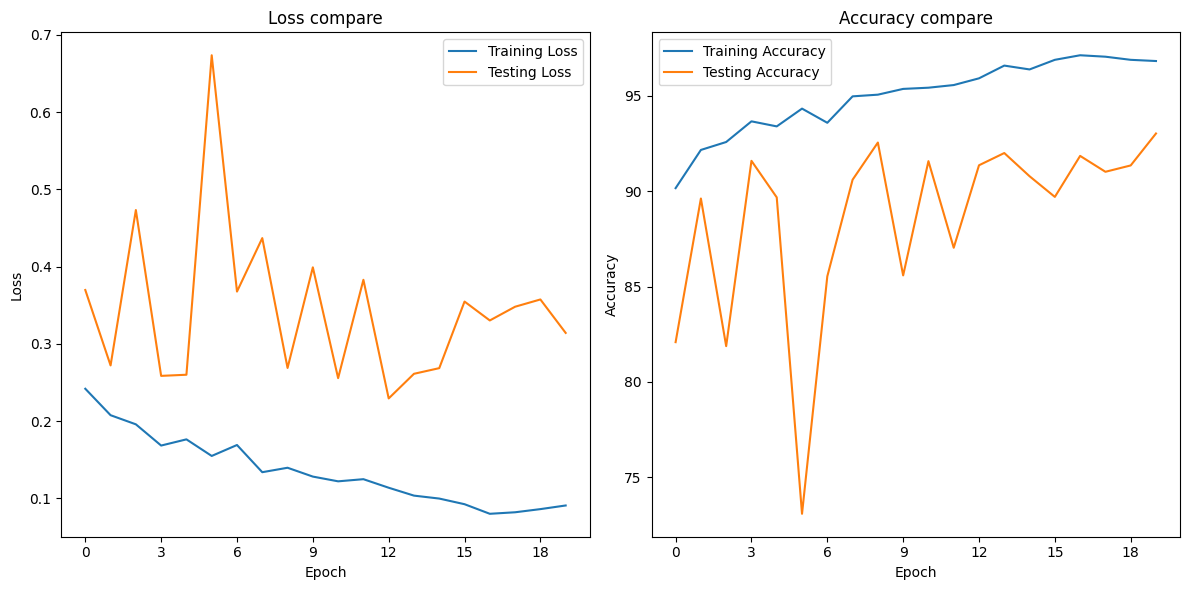

In [115]:
import matplotlib.pyplot as plt
import json
from matplotlib.ticker import MaxNLocator



n_epochs = len(running_loss_list)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(np.arange(start, start+n_epochs,dtype=int), running_loss_list, label='Training Loss')
ax[0].plot(np.arange(start, start+n_epochs,dtype=int), testing_loss_list, label='Testing Loss')
ax[0].set_title('Loss compare')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))  # 設置 X 軸只顯示整數

ax[1].plot(np.arange(start, start+n_epochs,dtype=int), running_accu_list, label='Training Accuracy')
ax[1].plot(np.arange(start, start+n_epochs,dtype=int), testing_accu_list, label='Testing Accuracy')
ax[1].set_title('Accuracy compare')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))  # 設置 X 軸只顯示整數

plt.tight_layout()

figname = f'{os.path.dirname(savepath)}/{model_name}_loss.png'
if os.path.isfile(figname):
  print(f"{figname} exist.")
else:
  plt.savefig(figname)
plt.show()

lossname = f'{os.path.dirname(savepath)}/{model_name}_loss.json'


#若是從checkpoint跑模型,把loss data接上去,loss data預設在模型參數資料夾下
if os.path.isfile(lossname):
  with open(lossname, 'r') as f:
    data_to_save = json.load(f)
  data_to_save['running_loss_list'].extend(running_loss_list)
  data_to_save['testing_loss_list'].extend(testing_loss_list)
  data_to_save['running_accu_list'].extend(running_accu_list)
  data_to_save['testing_accu_list'].extend(testing_accu_list)
else:
  data_to_save = {
      'running_loss_list': running_loss_list,
      'testing_loss_list': testing_loss_list,
      'running_accu_list': running_accu_list,
      'testing_accu_list': testing_accu_list
  }

with open(lossname, 'w') as f:
    json.dump(data_to_save, f, indent=4)

# 儲存模型參數



In [37]:
print(f'{model_name}_{epoch}')
print(f'{modeldirname}')

NameError: name 'epoch' is not defined

In [99]:

filename = save_model(model)


params = {
    'num_epochs': epoch,
    'batch_size': batch_size,
    'learning_rate': lr,
    'droprate': droprate
}

if os.path.isfile(filename+'.json'):
    print(f"{filename}.json exist.")
else:
    with open(f'{filename}.json', 'w') as f:
        json.dump(params, f)

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params//
請輸入模型儲存的檔名:efficientnet_b0_94
請輸入模型儲存的資料夾:tf_efficientnetv2_b0_ADAM_cosannealing
/content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/tf_efficientnetv2_b0_ADAM_cosannealing/efficientnet_b0_94.pth exist.


# 讀取模型參數

In [140]:
model = pretrained_model
# model = unet_model
print(model_name)

efficientnet_b0


In [141]:
model = model.to(device)
model ,_ ,params ,_ = load_model(model)

請輸入模型參數檔案名稱:efficientnet_b0_10
請輸入儲存模型的母資料夾名稱:tf_efficientnetv2_b0_ADAM_cosannealing_nonormal
<All keys matched successfully>


# 單次評估


In [ ]:
# 評估設置
try:
  batch_size = params['batch_size']
except:
  batch_size = int(input("batch_size:"))
print(batch_size)


valid_dataset = CustomDataset(images_train, labels_train, transform=transform_standard)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
criterion = nn.BCELoss()
valid_loss, valid_accuracy, predict_list = valid(valid_loader, model, criterion, 0.5, device)

print(f"Accuracy of the network on the test images: {valid_accuracy}%")
print(f"Loss: {valid_loss}")
predict_listq = predict_list.cpu()


Accuracy of the network on the 15592   
training images: 99.20472036942022%  
Loss: 0.03187363331013983


In [ ]:
print_results(predict_listq, labels[:len(predict_listq)])

# 測試

In [142]:
testdir = "Cropped_60-316_150-406_11-71/Test_Image_cropped"

In [20]:
from google.auth.transport.requests import Request
request = Request()
credentials.refresh(request)
loop.run_until_complete(get_data_disk_async(drive_rootdir, testdir,token = credentials.token))

making Cropped_60-316_150-406_11-71/Test_Image_cropped dir...


100%|██████████| 200/200 [00:10<00:00, 19.47it/s]


In [21]:
images_test, info = read_test(testdir,termi=200,shift=0)

0: Read test Zx0E3C20D9BB248666F8C1605B9A9D726237A5626AD91AF5DF finished...
1: Read test Zx760621E0AF1739CDC30E3925F0FE271EB515E4314C2926EE finished...
2: Read test ZxCE42C31F5FC5F2B9EF2F36E7EB5B096F0C7F4F25E2AB0445 finished...
3: Read test Zx00FE1B9A88E88C71917ECC1EDD774252C072CA5FDB12C01B finished...
4: Read test ZxE5CBD5D7C3EBE3E942304BD4EB09A7A83E3BC794E9E33B83 finished...
5: Read test ZxFF51EAF10B09D34CAEEEA49B2A8310C1011E389C1AFE6C8B finished...
6: Read test ZxCCB3EEF9389115B6F0ECCF3C05DB35F72DF7F4687E2CAAAE finished...
7: Read test ZxC049A25D75C5FC9B7261ECB00B16D05743D36782F8D868F2 finished...
8: Read test Zx256A9E945D19FB28335E22C805EC9CDC4F4E23A7B3871D4F finished...
9: Read test ZxE7E2340E9CF9166BA6232EE39329B72C09CBCC193F17F22F finished...
10: Read test ZxE0AE769C4E0DA3D095EF59A5158D7D0E0FB8881C1C87290D finished...
11: Read test Zx61704E649960C4025BB3AA0B31C1A75C71442BF48DAC3E19 finished...
12: Read test ZxEB847811235EA8F873A7C4C53779694E0E2473C003B04374 finished...
13: Read 

In [143]:
len(images_test)

12000

In [144]:
try:
  batch_size = params['batch_size']
except:
  batch_size = int(input("batch_size:"))
print(batch_size)


# 對testing dataset做normalization
dataset = CustomDataset(images_test, None, mode='test', transform=None)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)


batch_size:128
128


In [145]:
model.eval()

predict_list = torch.tensor([]).to(device)
with torch.no_grad():  # 不更新梯度
    for j, batch_images in enumerate(dataloader):
        batch_images = batch_images.to(device)
        outputs = model(batch_images)
        predicted = (outputs.squeeze() > 0.5).int()

        # if predicted.dim() == 0:
        #   predicted = predicted.unsqueeze(0)
        predict_list = torch.cat((predict_list,predicted),0)


predict_listq = predict_list.cpu()

In [146]:
predict_listq.sum()

tensor(1246.)

# 輸出至提交格式

images讀進來是疊在一起的。 需要info紀錄images檔名順序與分割情況

In [147]:
dflable = read_label(labelpath)

In [148]:
pattern = re.compile(r'.*_[0-9]+$')  # 正則表達式匹配 "_數字" 結尾
mask = dflable.index.str.match(pattern)
scan_guess = np.array(dflable[mask]['label'])

訓練過程不改變資料順序, 所以輸出順序同輸入.   
predict值跟隨images順序, 照著info把每個predict值(label)與檔名(id)對上. 輸出成提交格式

In [149]:
def yes(predict):
  return int(sum(predict) >= 3)



predict_list = predict_listq.numpy()

## 還原id與對應label，假設key按照scan輸入順序排列,每個key對應的scan的cuts數是nslice
output = {}
k = 0  #第幾個scan
ii = 0   #每個key輪到第幾個
id, nslice = info[k][0], info[k][1]
for i in range(len(predict_list)):

  if (ii >= nslice):
    #該換下一個scan了
    output[id] = yes(predict_list[i-nslice:i]) #評估方式

    k += 1
    ii = 0
    id, nslice = info[k][0], info[k][1]

  label = predict_list[i]
  output[id+f'_{ii}'] = int(predict_list[i])
  ii += 1

output[id] = yes(predict_list[(i+1)-ii:]) #補上最後一個scan評估
output = list(output.items())
dfout = pd.DataFrame(output)
dfout.columns = ['id', 'label']
dfout = dfout.sort_values(by='id', key=lambda x: x.map(custom_sort_key)) #把母label移動到子label前面
filename = input("輸入提交路徑 (empty for submission\submission.csv)")
dfout.to_csv(os.path.join(drive_rootdir,'params','submission',filename)+'.csv', index=False)

輸入提交路徑 (empty for submission\submission.csv)efficientnet_b0_10_nonormal


# 讀取提交格式的檔案

In [ ]:
dftest = read_submission('fisrt_80.csv')
# dftest = read_submission('submission.csv')
dflabel = read_label("TrainValid_ground_truth.csv")

In [ ]:
len(dftest)

In [ ]:
import re


# 抓出scan-level data
pattern = re.compile(r'.*_[0-9]+$')  # 正則表達式匹配 "_數字" 結尾
mask = ~dftest.index.str.match(pattern)
scan_guess = np.array(dftest[mask]['label'])
scan_truth = np.array(dflabel.loc[dftest[mask]['label'].index]['label'])

mask = ~mask
cut_guess = np.array(dftest[mask]['label'])
cut_truth = np.array(dflabel.loc[dftest[mask]['label'].index]['label'])

In [ ]:
ss = 10
print("="*ss + "F1 score on scan level" + "="*ss)
print_results(scan_guess, scan_truth)
print(),print()
print("="*ss + "F1 score on cut level" +"="*ss )
print_results(cut_guess, cut_truth)

# 其他指令
不在工作流
臨時使用

**驗證數據集標準化**

In [ ]:
from torch.utils.data import DataLoader
import torch

def calculate_mean_std(dataset):
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=0)

    # 初始化总和和平方总和变量，以及样本数量
    total_sum = 0.0
    total_sq_sum = 0.0
    total_count = 0

    for data in dataloader:
        images, _ = data  # 假设每个数据是 (image, label) 格式

        # 将图像数据移至CPU并转换为一维
        images = images.view(images.size(0), -1)
        total_sum += images.sum(dim=1).sum(dim=0)
        total_sq_sum += (images ** 2).sum(dim=1).sum(dim=0)
        total_count += images.size(0) * images.size(1)

    # 计算总平均值和标准差
    mean = total_sum / total_count
    std = (total_sq_sum / total_count - mean ** 2) ** 0.5

    return mean, std




In [ ]:
import torch
# 獲取數據
images, labels = process_data2(datadir, termi=100, dropFalse=0)

In [ ]:

# 計算原始圖片mean
original_mean = torch.mean(images)
original_std = torch.std(images)
print(f'Original Mean: {original_mean}')
print(f'Original Std: {original_std}')

# 製作數據集
transform = transforms.Normalize(mean=original_mean, std=original_std)
dataset = CustomDataset(images, labels , transform=transform)
normalized_mean, normalized_std = calculate_mean_std(dataset)


# 输出
print(f'Normalized Mean: {normalized_mean}')
print(f'Normalized Std: {normalized_std}')



# # 計算原始圖片mean
# original_mean = torch.mean(images)
# original_std = torch.std(images)
# print(f'Original Mean: {original_mean}')
# print(f'Original Std: {original_std}')

# # 製作數據集
# transform = transforms.Normalize(mean=original_mean, std=original_std)
# dataset = CustomDataset(images, labels)

# normalized_images, normalized_labels = dataset[:]
# normalized_mean, normalized_std = torch.mean(normalized_images), torch.std(normalized_images)


# print(f'Normalized Mean: {normalized_mean}')
# print(f'Normalized Std: {normalized_std}')


**下載每個checkpoint的參數並validate**

In [ ]:
filelist = os.listdir('/content/drive/MyDrive/AOCR2024/params/tf_efficientnetv2_s_SGD_cosannealing')
current_folder = 'tf_efficientnetv2_s_SGD_cosannealing'

In [ ]:
# model = unet_model
model = pretrained_model

model = model.to(device)
print(model_name)

criterion = nn.BCELoss()

tf_efficientnetv2_s


In [ ]:
train_id, valid_id = get_split()
images_valid, labels_valid = process_data2(datadir, dropFalse=0, files=valid_id)
images_validtrain, labels_validtrain =  process_data2(traindir=datadir,dropFalse=0,dropPos=0, files=train_id)

reading traindir='Cropped_60-316_150-406_11-71/Train_Valid_Image_cropped'...
xlim=[60, 316]
ylim=[150, 406]
zlim=[11, 71]
Process 0: Zx015DF8E20804DB94E24A9B2D9DD387A47EF1C620A02026DC finished...
Process 1: Zx01F90B532F87127DB647612B6621F2065CA58692B921CEB4 finished...
Process 2: Zx0494BD052F6F8D5A583699BBC329C318AC7B5BE50FD9ACDA finished...
Process 3: Zx0800DE5C96380322C65ABA398FC93B5CBDF75B20B11DDF6E finished...
Process 4: Zx09972B8FA6215EEC75DB4194B16C000F47B5F87AFB64A12B finished...
Process 5: Zx0A1564C092259CD377329E07006281E876D09F9B48E77002 finished...
Process 6: Zx0AE5424009C101F7422C5BD9DD2C3B0E13E834114A32883A finished...
Process 7: Zx0BA755CD6D068378215FE1AE4751945053ED5D2F2C2A40E7 finished...
Process 8: Zx0CA5CE197AA9378EE23F949BDFC91790D4FED5D6FD06F5A2 finished...
Process 9: Zx0CFB1637BD27964BE741B2AA07BC7C84B2B61731E47782E0 finished...
Process 10: Zx0E094D2402D05592511D0DED9E7ED9E999B468C249E9253F finished...
Process 11: Zx0E96DE51997AF17C5C54835EAD6B7512C66F91BFDB491B9F 

In [ ]:
batch_size = 64
mean_train_, std_train_ = torch.mean(images_validtrain), torch.std(images_validtrain)
transform_train_ = transforms.Normalize(mean=mean_train_, std=std_train_)
validtrain_dataset = CustomDataset(images_validtrain, labels_validtrain, transform=transform_train_)
validtrain_loader = DataLoader(validtrain_dataset, batch_size=batch_size, shuffle=True, drop_last=False)

valid_dataset = CustomDataset(images_valid, labels_valid, mode='valid', transform=transform_train_)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, drop_last=False)

running_loss_list = []
testing_loss_list = []
running_accu_list = []
testing_accu_list = []

for current_model in filelist[2:]:
  model,_,params,_ = load_model(model, modelname=current_model.rstrip('.pth'),dirname=current_folder)


  epoch_loss, epoch_accuracy, predict_list_validtrain, predict_labels_validtrain  = valid(validtrain_loader, model, criterion, 0.5, device)
  valid_loss, valid_accuracy, predict_list, predict_labels_valid = valid(valid_loader, model, criterion, 0.5, device)

  running_loss_list.append(epoch_loss)
  testing_loss_list.append(valid_loss)
  running_accu_list.append(epoch_accuracy)
  testing_accu_list.append(valid_accuracy)

  predict_listq = predict_list.cpu()
  predict_listq_validtrain = predict_list_validtrain.cpu()

  print(f"Accuracy of the {current_model} on the valid images: {valid_accuracy}%")
  print(f"Loss: {valid_loss}")
  print_results(predict_listq, predict_labels_valid)


  print(f"Accuracy of the {current_model} on the validtrain images: {epoch_accuracy}%")
  print(f"Loss: {epoch_loss}")
  print_results(predict_listq_validtrain, predict_labels_validtrain)

<All keys matched successfully>
Accuracy of the tf_efficientnetv2_s_20.pth on the valid images: 92.99166666666666%
Loss: 0.4579299952527706

      真實值
  預  +-----+-----+
  測| TP: 245| FP: 177|
  值| FN: 664| TN: 10914|
      +-----+-----+ 

recall=0.26952695269526955
precision=0.580568720379147
F1=0.3681442524417732

Accuracy of the tf_efficientnetv2_s_20.pth on the validtrain images: 99.86866244162775%
Loss: 0.003950398122997285

      真實值
  預  +-----+-----+
  測| TP: 224| FP: 3426|
  值| FN: 3365| TN: 40953|
      +-----+-----+ 

recall=0.06241292839230984
precision=0.06136986301369863
F1=0.06188700096698439

<All keys matched successfully>


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import json
from matplotlib.ticker import MaxNLocator

savepath = "/content/drive/MyDrive/AOCR2024/params/tf_efficientnetv2_s_cos/tf_efficientnetv2_s_400"
n_epochs = len(running_loss_list)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot( running_loss_list, label='Training Loss')
ax[0].plot( testing_loss_list, label='Testing Loss')
ax[0].set_title('Loss compare')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))  # 設置 X 軸只顯示整數

ax[1].plot( running_accu_list, label='Training Accuracy')
ax[1].plot( testing_accu_list, label='Testing Accuracy')
ax[1].set_title('Accuracy compare')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))  # 設置 X 軸只顯示整數

plt.tight_layout()

figname = f'{os.path.dirname(savepath)}/{model_name}_loss.png'
if os.path.isfile(figname):
  print(f"{figname} exist.")
else:
  plt.savefig(figname)
plt.show()

lossname = f'{os.path.dirname(savepath)}/{model_name}_loss.json'


#若是從checkpoint跑模型,把loss data接上去,loss data預設在模型參數資料夾下
if os.path.isfile(lossname):
  with open(lossname, 'r') as f:
    data_to_save = json.load(f)
  data_to_save['running_loss_list'].extend(running_loss_list)
  data_to_save['testing_loss_list'].extend(testing_loss_list)
  data_to_save['running_accu_list'].extend(running_accu_list)
  data_to_save['testing_accu_list'].extend(testing_accu_list)
else:
  data_to_save = {
      'running_loss_list': running_loss_list,
      'testing_loss_list': testing_loss_list,
      'running_accu_list': running_accu_list,
      'testing_accu_list': testing_accu_list
  }

with open(lossname, 'w') as f:
    json.dump(data_to_save, f, indent=4)

drive檔案處理

重命名檔案

In [ ]:
cd /content/drive/MyDrive/AOCR2024/params

In [ ]:
# %shell for file in tf_efficientnetv2_m*; do mv "$file" "${file/tf_efficientnetv2_m/unet}"; done